In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Colab\ Notebooks/RL/VAE

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/RL/VAE


In [ ]:
!pip install Ipython --upgrade
!pip install numpy==1.22.4
!pip install acme==1.31.0
!pip install dm-acme==0.4.0
!pip install dm-control==0.0.364896371
!pip install dm-env==1.5
!pip install dm-haiku==0.0.9
!pip install dm-launchpad==0.5.0
!pip install dm-reverb==0.7.0
!pip install dm-sonnet==2.0.0
!pip install dm-tree==0.1.7
!pip install trfl
!pip install protobuf==3.20.3
!pip install tensorflow==2.8.0
!pip install tensorflow-datasets==4.4.0
!pip install tensorflow-estimator==2.8.0
!pip install tensorflow-io-gcs-filesystem==0.28.0
!pip install tensorflow-metadata==1.11.0
!pip install tensorflow-probability==0.15.0
!pip install torch
!pip install vae
!pip install matplotlib
!pip install scipy
!pip install cuda-python

In [ ]:
import numpy as np
import pandas as pd
import yfinance
import statsmodels.formula.api as smf
import statsmodels.api as smi
from table_making import summary_col
import matplotlib.pyplot as plt
import re

# Download VIX data

In [ ]:
vix = yfinance.download("^VIX", start="1990-01-01", end="2023-07-01")
vix.head()

In [ ]:
vix.to_csv("data/VIX.csv")

# Load VIX and surface data

In [ ]:
vix = pd.read_csv("data/VIX.csv")
vix.head()

In [ ]:
vix = vix[["Date", "Close"]].rename(columns={"Date": "date", "Close": "VIX"})
vix.head()

In [ ]:
vix["delta_VIX"] = vix["VIX"] - vix["VIX"].shift(1)
vix["abs_delta_VIX"] = vix["delta_VIX"].abs()
vix.head()

In [ ]:
spx_df = pd.read_parquet("data/spx_vol_surface_history_full_data_23.parquet").reset_index().rename(columns={"index": "date"})
spx_df.head()

In [ ]:
vix["date"] = vix["date"].astype("datetime64[D]")
spx_df2 = pd.merge(spx_df, vix, how="left", on=["date"])
spx_df2 = spx_df2.dropna()
spx_df2.head()

In [ ]:
vix.to_csv("data/vix_processed.csv", index=False)

In [ ]:
spx_df2.to_parquet("data/spx_with_vix.parquet", index=False)

# Use the VVIX Instead

In [ ]:
vvix = yfinance.download("^VVIX", start="1990-01-01", end="2023-07-01")
vvix.head()


In [ ]:
vvix.to_csv("data/VVIX.csv")

In [ ]:
vvix = pd.read_csv("data/VVIX.csv")
vvix.head()

In [ ]:
vvix = vvix[["Date", "Close"]].rename(columns={"Date": "date", "Close": "VVIX"})
vvix.head()

In [ ]:
vvix["delta_VVIX"] = vvix["VVIX"] - vvix["VVIX"].shift(1)
vvix["abs_delta_VVIX"] = vvix["delta_VVIX"].abs()
vvix.head()
spx_df = pd.read_parquet("data/spx_vol_surface_history_full_data_23.parquet").reset_index().rename(columns={"index": "date"})
spx_df.head()
vvix["date"] = vvix["date"].astype("datetime64[D]")
spx_df3 = pd.merge(spx_df, vvix, how="left", on=["date"])
spx_df3 = spx_df3.dropna()
spx_df3.head()
vvix.to_csv("data/vvix_processed.csv", index=False)
spx_df3.to_parquet("data/spx_with_vvix.parquet", index=False)

# regression

In [ ]:
def latex_format(sm):
    ltx = sm.as_latex()
    ltx = re.sub(r" +", " ", ltx)
    ltx = ltx.replace(" & VIX & abs\\_delta\\_VIX \\\\\n\\hline", """ & VIX & $|\\text{VIX}_t - \\text{VIX}_{t-1}|$ \\\\
\cmidrule(lr){2-2} \cmidrule(lr){3-3}""")
    ltx = ltx.replace("iv\_atm\_std", "std($\\text{iv}_{\\text{ATM}}$)")
    ltx = ltx.replace("R-squared Adj.", "\\hline\n$R^2$")
    ltx = ltx.replace("\\$N\\$", "$N$")
    ltx = ltx.replace("""lll""", """lcc""")
    ltx = ltx.replace("cc}\n\\hline", "cc}\n\\hline\\hline")
    ltx = ltx.replace("\\begin{table}\n\\caption{}\n\\label{}\n\\begin{center}\n", "")
    ltx = ltx.replace("\\end{center}\n\\end{table}", "")
    return ltx

In [ ]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")

simulated_surfaces = np.load("test_spx/simpath/conv_mem_spx_ex3_0_gen3.npy") # no loss on ex_feats
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

simulation2 = np.load("test_spx/simpath/ex3_model_0_gen3.npz") # loss on ret only
simulated_surfaces2 = simulation2["surfaces"]
simulated_atm2 = simulated_surfaces2[:, :, 3, 2]
simulated_atm_std2 = np.std(simulated_atm2, axis=1)

simulation3 = np.load("test_spx/simpath/conv_mem_spx_ex3_1_gen3.npz") # loss on every ex_features, ret, skew, slope
simulated_surfaces3 = simulation3["surfaces"]
simulated_atm3 = simulated_surfaces3[:, :, 3, 2]
simulated_atm_std3 = np.std(simulated_atm3, axis=1)

In [ ]:
regression_df = spx_df.loc[4950:5050-1, ["date", "VIX", "delta_VIX", "abs_delta_VIX"]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std
regression_df2 = regression_df.copy()
regression_df2["iv_atm_std"] = simulated_atm_std2
regression_df3 = regression_df.copy()
regression_df3["iv_atm_std"] = simulated_atm_std3

In [ ]:
models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
print(latex_format(sm))

In [ ]:
models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df2).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
print(latex_format(sm))

In [ ]:
models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df3).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
print(latex_format(sm))

# Long timewindow

In [ ]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
#spx_df["VIX"] = -1 / spx_df["VIX"] # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulation = np.load("test_spx/simpath/gen_5300_1000_3_l1.npz") # loss on ret
simulated_surfaces = simulation["surfaces"]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5300-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

In [ ]:
regression_df.shape

In [ ]:
regression_df1["date"]

In [ ]:
models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
print(latex_format(sm))

In [ ]:
sm

In [ ]:
model = smf.ols(f"VIX~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_std"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_std"], regression_df1["VIX"], s=0.2)
plt.xlabel("std iv atm")
plt.ylabel("VIX")
plt.show()

In [ ]:
all_y = ["VIX"] + [f"VIX_p{i}" for i in range(1, 11)]
ts = []
betas = []
cins = [] # 95% low CI
cips = [] # 95% high CI
# pvs = [] # p values
for t, y in enumerate(all_y):
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    ci = model.conf_int(alpha=0.95)
    ts.append(t)
    betas.append(model.params["iv_atm_std"])
    cins.append(ci.loc["iv_atm_std", 0])
    cips.append(ci.loc["iv_atm_std", 1])
    # pvs.append(model.pvalues["iv_atm_std"])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(ts, betas, color="blue", label="beta")
ax.fill_between(ts, cins, cips, color="lightsteelblue", alpha=0.2)
ax.set_xlabel("t days from predicted surface")
ax.set_ylabel("beta")
# ax_twin = ax.twinx()
# ax_twin.plot(ts, pvs, color="yellow", label="p-values")
# ax_twin.set_ylabel("p-value")
plt.show()

In [ ]:
all_y = ["abs_delta_VIX"] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]
ts = []
betas = []
cins = [] # 95% low CI
cips = [] # 95% high CI
pvs = [] # p values
for t, y in enumerate(all_y):
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    ci = model.conf_int(alpha=0.95)
    ts.append(t)
    betas.append(model.params["iv_atm_std"])
    cins.append(ci.loc["iv_atm_std", 0])
    cips.append(ci.loc["iv_atm_std", 1])
    # pvs.append(model.pvalues["iv_atm_std"])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(ts, betas, color="blue", label="beta", linewidth=0.3)
ax.fill_between(ts, cins, cips, color="gray", alpha=0.3)
ax.set_xlabel("t days from predicted surface")
ax.set_ylabel("beta")
# ax_twin = ax.twinx()
# ax_twin.plot(ts, pvs, color="yellow", label="p-values")
# ax_twin.set_ylabel("p-value")
plt.show()

## with l2 loss

In [ ]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulation = np.load("test_spx/simpath/gen_5300_1000_3_l2.npz") # loss on ret
simulated_surfaces = simulation["surfaces"]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

In [ ]:
models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
print(sm)


                   VIX      abs_delta_VIX
-----------------------------------------
iv_atm_std     4492.4224*** 325.0777***  
               (92.47)      (24.17)      
Intercept      -9.5949***   -1.0703***   
               (0.57)       (0.15)       
R-squared Adj. 0.660        0.127        
$N$            5300         5300         
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
sm

,VIX,abs_delta_VIX
iv_atm_std,4492.4224***,325.0777***
,(92.47),(24.17)
Intercept,-9.5949***,-1.0703***
,(0.57),(0.15)
R-squared Adj.,0.660,0.127
$N$,5300,5300


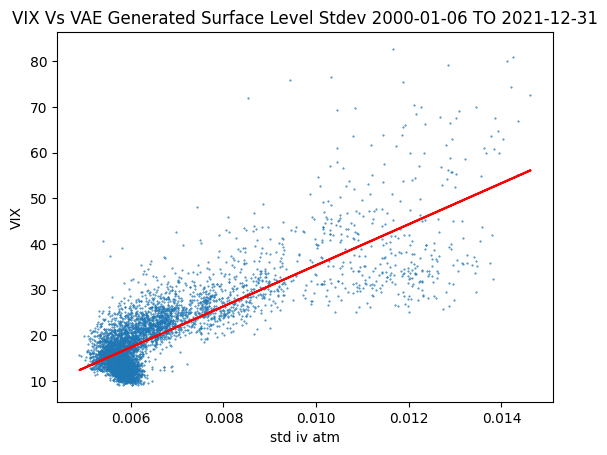

In [ ]:
model = smf.ols(f"VIX~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_std"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_std"], regression_df1["VIX"], s=0.2)
plt.xlabel("std iv atm")
plt.ylabel("VIX")
plt.title("VIX Vs VAE Generated Surface Level Stdev 2000-01-06 TO 2021-12-31")
plt.show()

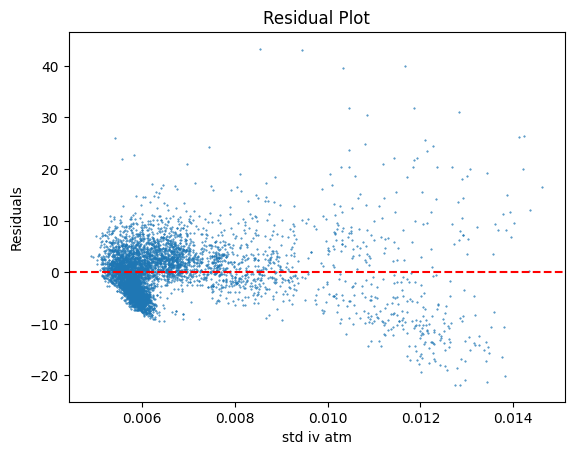

In [ ]:
# Calculate residuals
residuals = regression_df1["VIX"] - model.predict()

# Plot residuals against iv_atm_std
plt.scatter(regression_df1["iv_atm_std"], residuals, s=0.2)
plt.axhline(y=0, color="red", linestyle="--")  # Add a horizontal line at y=0
plt.xlabel("std iv atm")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

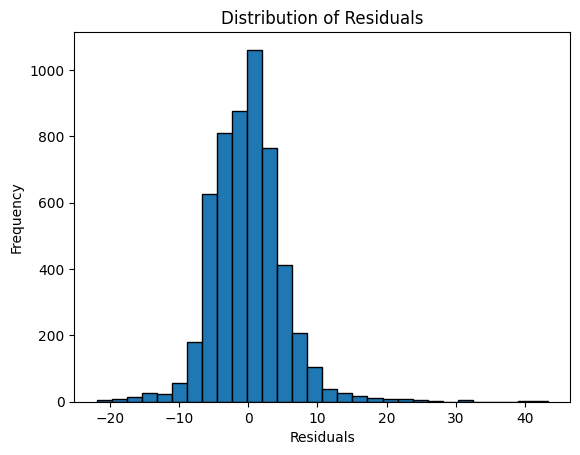

In [ ]:
# Plot histogram of residuals
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

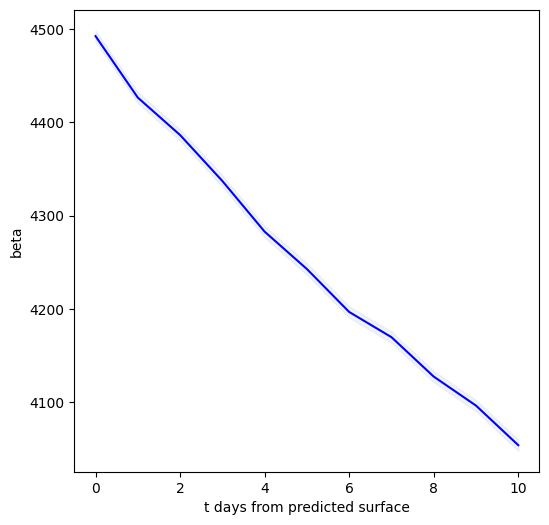

In [ ]:
all_y = ["VIX"] + [f"VIX_p{i}" for i in range(1, 11)]
ts = []
betas = []
cins = [] # 95% low CI
cips = [] # 95% high CI
# pvs = [] # p values
for t, y in enumerate(all_y):
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    ci = model.conf_int(alpha=0.95)
    ts.append(t)
    betas.append(model.params["iv_atm_std"])
    cins.append(ci.loc["iv_atm_std", 0])
    cips.append(ci.loc["iv_atm_std", 1])
    # pvs.append(model.pvalues["iv_atm_std"])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(ts, betas, color="blue", label="beta")
ax.fill_between(ts, cins, cips, color="lightsteelblue", alpha=0.2)
ax.set_xlabel("t days from predicted surface")
ax.set_ylabel("beta")
# ax_twin = ax.twinx()
# ax_twin.plot(ts, pvs, color="yellow", label="p-values")
# ax_twin.set_ylabel("p-value")
plt.show()

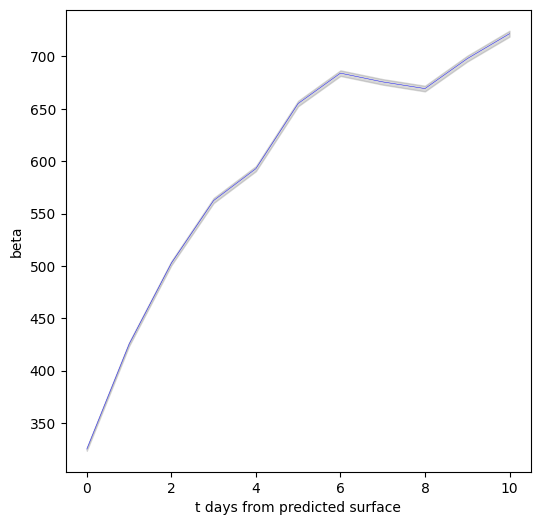

In [ ]:
all_y = ["abs_delta_VIX"] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]
ts = []
betas = []
cins = [] # 95% low CI
cips = [] # 95% high CI
pvs = [] # p values
for t, y in enumerate(all_y):
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    ci = model.conf_int(alpha=0.95)
    ts.append(t)
    betas.append(model.params["iv_atm_std"])
    cins.append(ci.loc["iv_atm_std", 0])
    cips.append(ci.loc["iv_atm_std", 1])
    # pvs.append(model.pvalues["iv_atm_std"])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(ts, betas, color="blue", label="beta", linewidth=0.3)
ax.fill_between(ts, cins, cips, color="gray", alpha=0.3)
ax.set_xlabel("t days from predicted surface")
ax.set_ylabel("beta")
# ax_twin = ax.twinx()
# ax_twin.plot(ts, pvs, color="yellow", label="p-values")
# ax_twin.set_ylabel("p-value")
plt.show()

L2 With mean Level Vs. VIX Instead

In [ ]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulation = np.load("test_spx/simpath/gen_5300_1000_3_l2.npz") # loss on ret
simulated_surfaces = simulation["surfaces"]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_mean = np.mean(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_mean"] = simulated_atm_mean


In [ ]:
models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_mean", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_mean", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
print(latex_format(sm))

\begin{tabular}{lcc}
\hline\hline
 & VIX & $|\text{VIX}_t - \text{VIX}_{t-1}|$ \\
\cmidrule(lr){2-2} \cmidrule(lr){3-3}
iv\_atm\_mean & 170.4885*** & 10.9283*** \\
 & (2.21) & (0.67) \\
Intercept & -12.9429*** & -1.0406*** \\
 & (0.39) & (0.12) \\
\hline
$R^2$ & 0.783 & 0.118 \\
$N$ & 5300 & 5300 \\
\hline
\end{tabular}

\bigskip
Standard errors in parentheses. \newline 
* p<.1, ** p<.05, ***p<.01


In [ ]:
sm

,VIX,abs_delta_VIX
iv_atm_mean,170.4885***,10.9283***
,(2.21),(0.67)
Intercept,-12.9429***,-1.0406***
,(0.39),(0.12)
R-squared Adj.,0.783,0.118
$N$,5300,5300


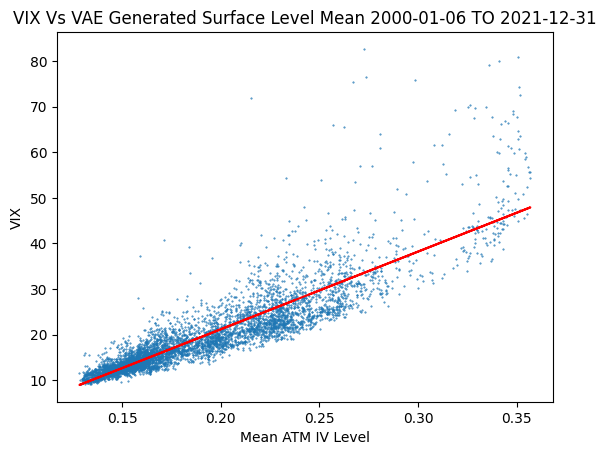

In [ ]:
model = smf.ols(f"VIX~1+iv_atm_mean", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_mean"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_mean"], regression_df1["VIX"], s=0.2)
plt.xlabel("Mean ATM IV Level")
plt.ylabel("VIX")
plt.title("VIX Vs VAE Generated Surface Level Mean 2000-01-06 TO 2021-12-31")
plt.show()

# Rolling Period Fitting

Mean Level

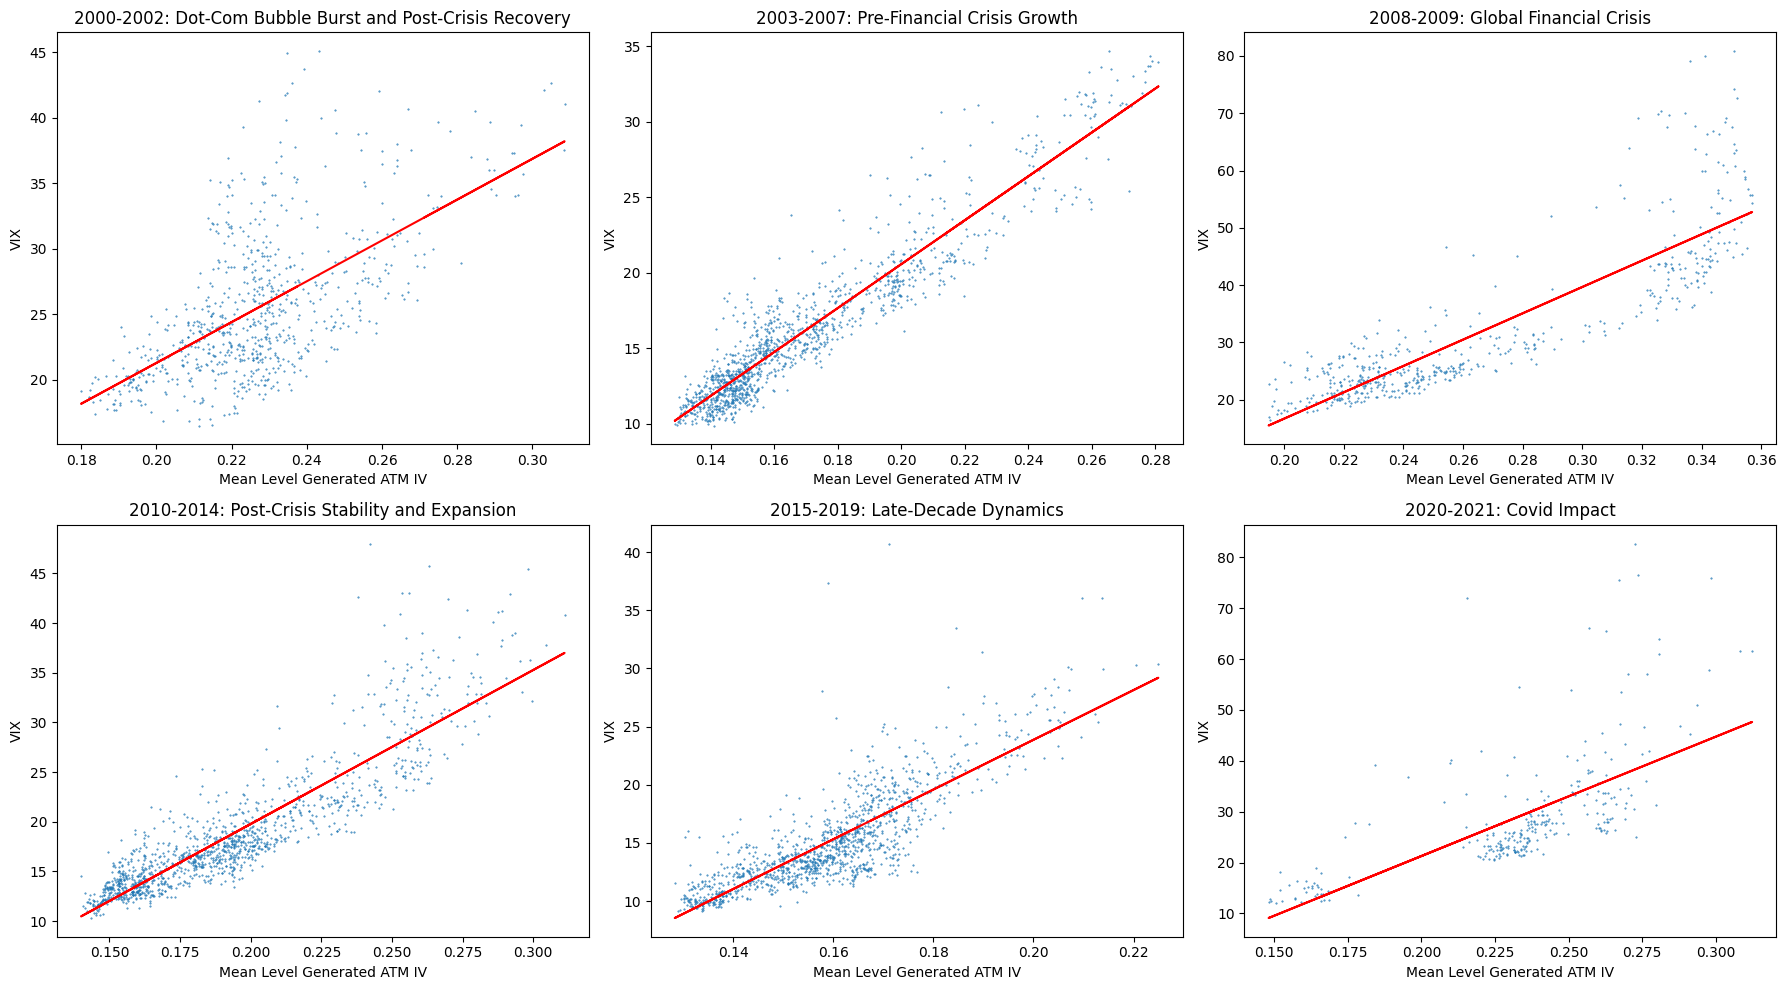

In [ ]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulation = np.load("test_spx/simpath/gen_5300_1000_3_l2.npz") # loss on ret
simulated_surfaces = simulation["surfaces"]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_mean = np.mean(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_mean"] = simulated_atm_mean

periods = [
    ("2000-2002", "Dot-Com Bubble Burst and Post-Crisis Recovery", pd.date_range("2000-01-06", "2002-12-31")),
    ("2003-2007", "Pre-Financial Crisis Growth", pd.date_range("2003-01-01", "2007-12-31")),
    ("2008-2009", "Global Financial Crisis", pd.date_range("2008-01-01", "2009-12-31")),
    ("2010-2014", "Post-Crisis Stability and Expansion", pd.date_range("2010-01-01", "2014-12-31")),
    ("2015-2019", "Late-Decade Dynamics", pd.date_range("2015-01-01", "2019-12-31")),
    ("2020-2021", "Covid Impact", pd.date_range("2020-01-01", "2021-12-31"))
]

num_subplots = len(periods)


num_cols = min(num_subplots, 3)
num_rows = (num_subplots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# now each period
for i, (period_date, period_title, period_range) in enumerate(periods):
    row, col = divmod(i, num_cols)

    ax = axes[row, col]

    subset_df = regression_df1[regression_df1["date"].isin(period_range)]

    # Perform regression and prediction
    model = smf.ols(f"VIX~1+iv_atm_mean", data=subset_df).fit(cov_type="HC3")
    y_pred = model.predict(subset_df)


    ax.plot(subset_df["iv_atm_mean"], y_pred, color="red")
    ax.scatter(subset_df["iv_atm_mean"], subset_df["VIX"], s=0.2)
    ax.set_xlabel("Mean Level Generated ATM IV")
    ax.set_ylabel("VIX")
    ax.set_title(f"{period_date}: {period_title}")


plt.tight_layout()
plt.show()

In [ ]:
# Loop through each period
for period_date, period_title, period_range in periods:
    subset_df = regression_df1[regression_df1["date"].isin(period_range)]

    models = []
    for y in ["VIX", "abs_delta_VIX"]:
      model = smf.ols(f"{y}~1+iv_atm_mean", data=subset_df).fit(cov_type="HC3")
      models.append(model)

    sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_mean", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
    print(f"\nStats for: {period_date}: {period_title}")
    print(sm)


Stats for: 2000-2002: Dot-Com Bubble Burst and Post-Crisis Recovery

                   VIX     abs_delta_VIX
----------------------------------------
iv_atm_mean    155.6310*** 11.3790***   
               (5.63)      (1.81)       
Intercept      -9.8215***  -1.4270***   
               (1.24)      (0.40)       
R-squared Adj. 0.375       0.055        
$N$            747         747          
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01

Stats for: 2003-2007: Pre-Financial Crisis Growth

                   VIX     abs_delta_VIX
----------------------------------------
iv_atm_mean    145.3712*** 6.3993***    
               (1.90)      (0.81)       
Intercept      -8.5094***  -0.3927***   
               (0.30)      (0.13)       
R-squared Adj. 0.884       0.071        
$N$            1258        1258         
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01

Stats for: 2008-2009: Global Financial Crisis

                   VIX     abs_delta_VIX
---------------

STDev Rolling

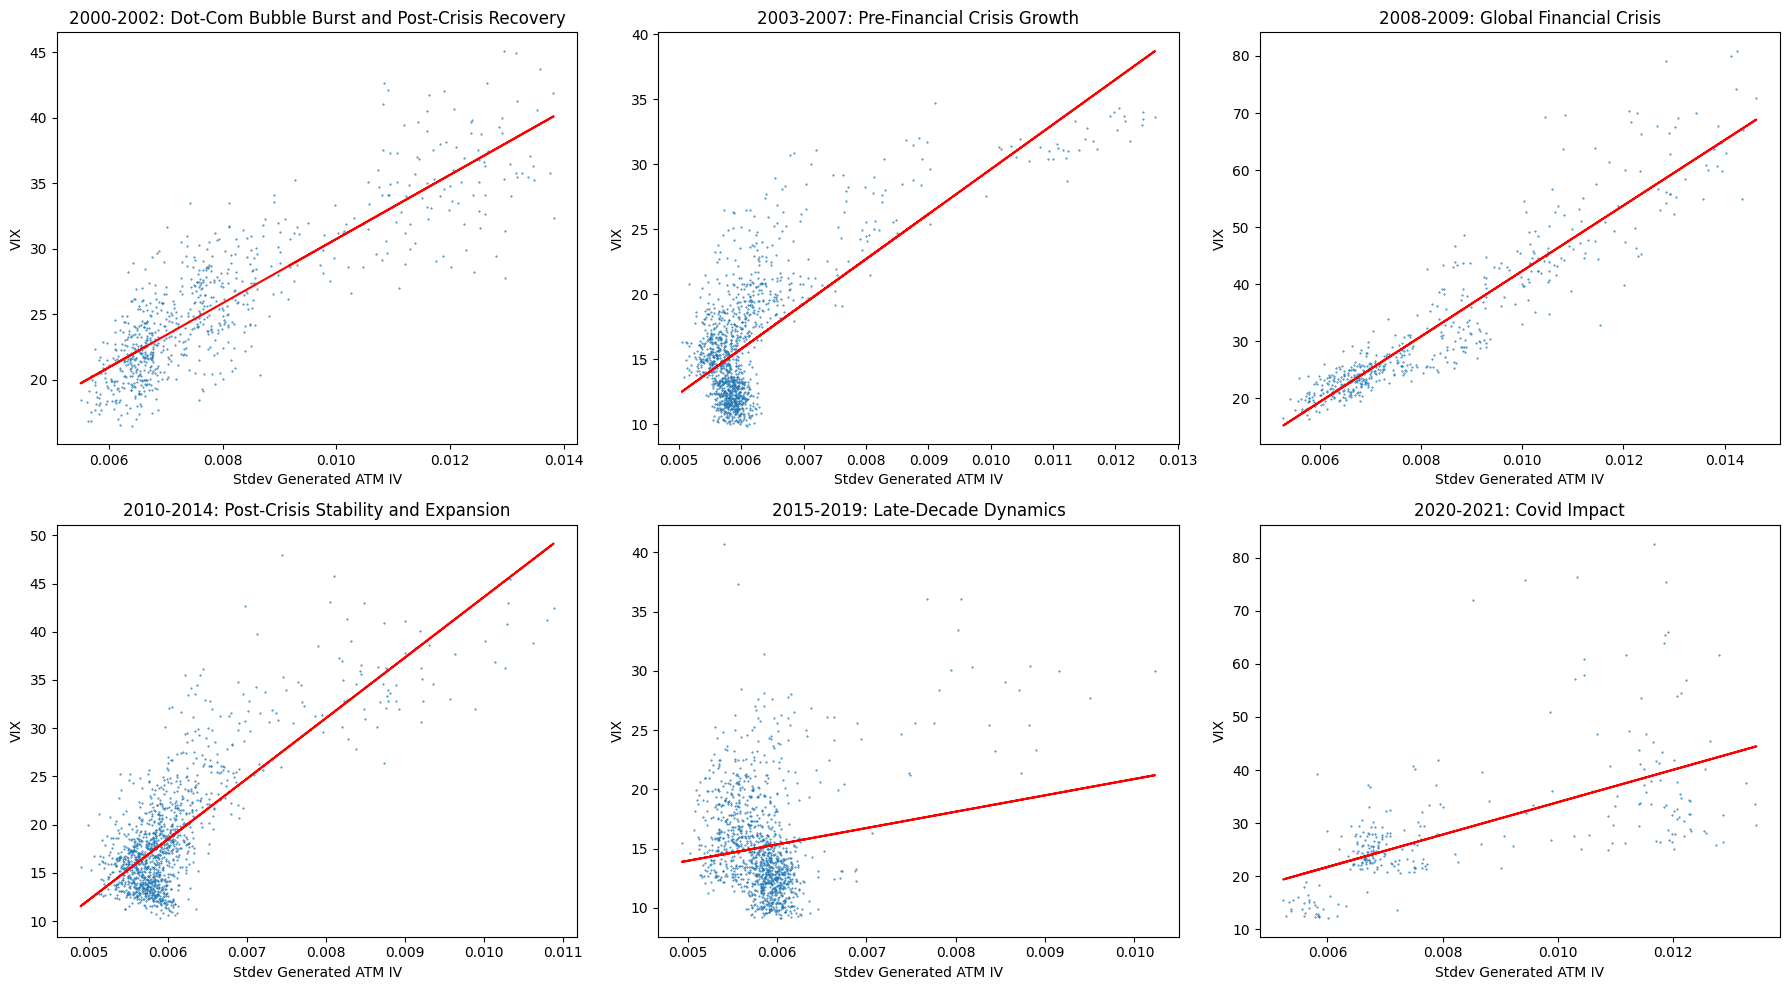

In [ ]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
spx_df["VIX"] = ((spx_df["VIX"])) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulation = np.load("test_spx/simpath/gen_5300_1000_3_l2.npz") # loss on ret
simulated_surfaces = simulation["surfaces"]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1,
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

periods = [
    ("2000-2002", "Dot-Com Bubble Burst and Post-Crisis Recovery", pd.date_range("2000-01-06", "2002-12-31")),
    ("2003-2007", "Pre-Financial Crisis Growth", pd.date_range("2003-01-01", "2007-12-31")),
    ("2008-2009", "Global Financial Crisis", pd.date_range("2008-01-01", "2009-12-31")),
    ("2010-2014", "Post-Crisis Stability and Expansion", pd.date_range("2010-01-01", "2014-12-31")),
    ("2015-2019", "Late-Decade Dynamics", pd.date_range("2015-01-01", "2019-12-31")),
    ("2020-2021", "Covid Impact", pd.date_range("2020-01-01", "2021-12-31"))
]


num_subplots = len(periods)

num_cols = min(num_subplots, 3)
num_rows = (num_subplots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

for i, (period_date, period_title, period_range) in enumerate(periods):
    row, col = divmod(i, num_cols)

    ax = axes[row, col]

    subset_df = regression_df1[regression_df1["date"].isin(period_range)]


    model = smf.ols(f"VIX~1+iv_atm_std", data=subset_df).fit(cov_type="HC3")
    y_pred = model.predict(subset_df)


    ax.plot(subset_df["iv_atm_std"], y_pred, color="red")
    ax.scatter(subset_df["iv_atm_std"], subset_df["VIX"], s=0.2)
    ax.set_xlabel("Stdev Generated ATM IV")
    ax.set_ylabel("VIX")
    ax.set_title(f"{period_date}: {period_title}")


plt.tight_layout()
plt.show()

In [ ]:

for period_date, period_title, period_range in periods:
    subset_df = regression_df1[regression_df1["date"].isin(period_range)]

    models = []
    for y in ["VIX", "abs_delta_VIX"]:
      model = smf.ols(f"{y}~1+iv_atm_std", data=subset_df).fit(cov_type="HC3")
      models.append(model)

    sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
    print(f"Stats for: {period_date}: {period_title}")
    print(sm)

Stats for: 2000-2002: Dot-Com Bubble Burst and Post-Crisis Recovery

                   VIX      abs_delta_VIX
-----------------------------------------
iv_atm_std     2448.4852*** 208.6641***  
               (69.26)      (26.48)      
Intercept      6.2671***    -0.4831**    
               (0.52)       (0.19)       
R-squared Adj. 0.738        0.148        
$N$            747          747          
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
Stats for: 2003-2007: Pre-Financial Crisis Growth

                   VIX      abs_delta_VIX
-----------------------------------------
iv_atm_std     3452.8962*** 77.8518***   
               (96.91)      (24.02)      
Intercept      -4.9248***   0.2171       
               (0.58)       (0.14)       
R-squared Adj. 0.513        0.010        
$N$            1258         1258         
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
Stats for: 2008-2009: Global Financial Crisis

                   VIX      abs_delta_VIX
-

# VVIX

In [ ]:
spx_df = pd.read_parquet("data/spx_with_vvix.parquet")
spx_df["VVIX"] = np.log(spx_df["VVIX"]) # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VVIX_p{i}"] = spx_df["VVIX"].shift(-i)
    spx_df[f"abs_delta_VVIX_p{i}"] = np.abs(spx_df[f"VVIX_p{i}"] - spx_df["VVIX"].shift(1))
simulation = np.load("test_spx/simpath/gen_5300_1000_3_l2.npz") # loss on ret
simulated_surfaces = simulation["surfaces"][1535:5303-1]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[0:len(spx_df),
["date", "VVIX", "delta_VVIX", "abs_delta_VVIX"] + [f"VVIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VVIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

In [ ]:
models = []
for y in ["VVIX", "abs_delta_VVIX"]:
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VVIX", "abs_delta_VVIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
print(latex_format(sm))

\begin{tabular}{lcc}
\hline\hline
 & VVIX & abs\_delta\_VVIX \\
\hline
std($\text{iv}_{\text{ATM}}$) & 1.3160 & 34.5975 \\
 & (2.27) & (49.78) \\
Intercept & 4.5080*** & 3.2416*** \\
 & (0.01) & (0.32) \\
\hline
$R^2$ & -0.000 & -0.000 \\
$N$ & 3765 & 3765 \\
\hline
\end{tabular}



In [ ]:
sm

,VVIX,abs_delta_VVIX
iv_atm_std,1.3160,34.5975
,(2.27),(49.78)
Intercept,4.5080***,3.2416***
,(0.01),(0.32)
R-squared Adj.,-0.000,-0.000
$N$,3765,3765


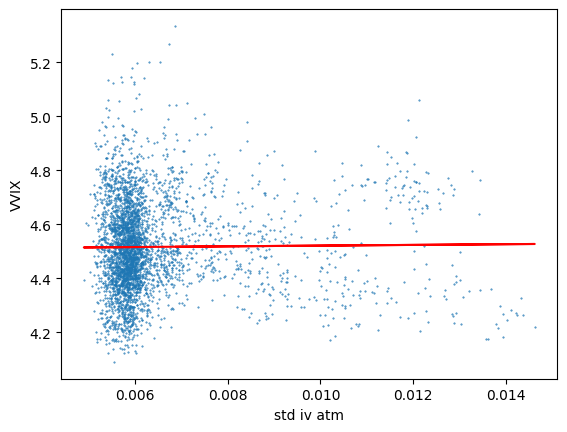

In [ ]:
model = smf.ols(f"VVIX~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_std"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_std"], regression_df1["VVIX"], s=0.2)
plt.xlabel("std iv atm")
plt.ylabel("VVIX")
plt.show()